### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 08 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 08 декабря, -4 балла после 08:30 15 декабря, -6 баллов после 08:30 22 декабря, -8 баллов после 08:30 29 декабря.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import defaultdict

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 5)

In [471]:
class MyDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        
        if self.criterion == 'gini':
            self.criterion_func = MyDecisionTreeClassifier.gini_on_pks
        elif self.criterion == 'entropy':
            self.criterion_func = MyDecisionTreeClassifier.entropy_on_pks
        elif self.criterion == 'error':
            self.criterion_func = MyDecisionTreeClassifier.error_on_pks
        else:
            raise ValueError(f'Criterion {self.criterion} is not suport')
        
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
    
    @classmethod
    def gini_crit(cls, x):
        pks = np.unique(x, return_counts = True)[1] / len(x)
        return 1 - np.sum(np.power(pks,2))
    
    @classmethod
    def error_crit(cls, x):
        pks = np.unique(x, return_counts = True)[1] / len(x)
        return 1 - np.max(pks)
    
    @classmethod
    def entropy_crit(cls, x):
        pks = np.unique(x, return_counts = True)[1] / len(x)
        return -np.sum(pks * np.nan_to_num(np.log(pks)))
    
    @classmethod
    def gini_on_pks(cls, pks):
        res = 1 - np.sum(np.power(pks,2), axis = 1)
        return res
    
    @classmethod
    def error_on_pks(cls, pks):
        return 1 - np.max(pks, axis = 1)
    
    @classmethod
    def entropy_on_pks(cls, pks):
        return -np.sum(pks * np.nan_to_num(np.log(pks)), axis = 1)
    
    
    def __feature_impurity(self, x, y, base_imp):
        arg_sort = np.argsort(x)
        y_sorted = y[arg_sort]
        x_sorted = x[arg_sort]

        x_unique, index_unique= np.unique(x_sorted, return_index = True)
        
        if len(x_unique) == 1: #если значение атрибута единственно, то нельзя делить 
            return [-1, -1]

        len_ = len(y)
        range_ = np.arange(len_)
        
        matrix_indicator = np.zeros((len_, self.num_class))
        matrix_indicator[range_, y_sorted] = 1
        
        sum_ = np.sum(matrix_indicator, axis = 0) # массив с числом элементов каждого класса 
        
        #матрица для распределений объектов по классам для каждого разбиения
        cs_right = np.cumsum(matrix_indicator[:-1], axis = 0)
        cs_left = (sum_ - cs_right)
        
        r_range_ = range_[1:]
        l_range_ = len_ - r_range_
        
        matrix_prob_right = cs_right / r_range_.reshape((-1,1)) 
        matrix_prob_left = cs_left / l_range_.reshape((-1,1))
        
        #тут мы считаем левые и правые гейны, разделяя y по каждому объекту.
        #но проблема в том, что в x могут быть не уникальные значение(значит некоторые разделения незаконны)
        
        gains_left = self.criterion_func(matrix_prob_left)
        gains_right = self.criterion_func(matrix_prob_right)

        impurity_arr = base_imp -  (gains_right * r_range_ + gains_left * (l_range_))/len_ #массив со всему impurity
        
        #а максимум будем искать среди тех, которые соответствуют индексам уникальных элементам x
        index = np.argmax(impurity_arr[index_unique[:-1]])

        thr_hold = (x_unique[index] + x_unique[index + 1]) / 2

        return [impurity_arr[index_unique[index]], thr_hold]

    
    def __find_threshold(self, x, y, verbose = False):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        base_pks = np.unique(y, return_counts = True)[1] / len(y)
        impurity_base = self.criterion_func(base_pks.reshape((1, -1))) #impurity вершины, которую делим
        
        imp_thr_pair = np.apply_along_axis(lambda col: self.__feature_impurity(col, y, impurity_base),
                                           axis =  0, arr =  x)

        f_num = np.argmax(imp_thr_pair[0]) #находим фичу с максимальным impurity
        threshold = imp_thr_pair[1, f_num] #порог который ей соответствует
        self.feature_importances_[f_num] += imp_thr_pair[0][f_num] #добавим impurity в словарь важности
        
        return  f_num, threshold

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        
        if self.max_depth == depth or len(y) < self.min_samples_split or len(np.unique(y)) == 1:
            curr_node = [MyDecisionTreeClassifier.LEAF_TYPE]
        else:
            curr_node = [MyDecisionTreeClassifier.NON_LEAF_TYPE]
            curr_node += list(self.__find_threshold(x, y))
  
            x_left, x_right, y_left, y_right = self.__div_samples(x, y, curr_node[1], curr_node[2])
                
            self.__fit_node(x_left, y_left, 2 * node_id + 1, depth + 1)
            self.__fit_node(x_right, y_right, 2 * node_id + 2, depth + 1)
        
        if curr_node[0] == MyDecisionTreeClassifier.LEAF_TYPE:
            value, counts = np.unique(y, return_counts = True)
            predict_ind = np.argmax(counts)
                
            curr_node += [value[predict_ind], counts[predict_ind] / len(y)]
        self.tree[node_id] = curr_node
        
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.feature_importances_ = { k : 0 for k in range(0,x.shape[1])}
        self.num_class = np.unique(y).size
        self.__fit_node(np.array(x), np.array(y), 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
    
    def __predict_class_prob(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class_prob(x, 2 * node_id + 1)
            else:
                return self.__predict_class_prob(x, 2 * node_id + 2)
        else:
            if node[1] == 1:
                return [1 - node[2], node[2]]
            else:
                return [node[2], 1 - node[2]]
    
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in np.array(X)])
    
    def predict_proba(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class_prob(x, 0) for x in np.array(X)])
    
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        values = np.array(list(self.feature_importances_.values()))
        return values / np.sum(values)

In [624]:
wine = load_wine()

In [625]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [626]:
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target,
                                                    test_size=0.1, stratify=wine.target)

In [627]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [628]:
my_clf.fit(X_train, y_train)

In [629]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test), accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

(0.8333333333333334, 0.8333333333333334)

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [512]:
%time clf.fit(X_train, y_train)

Wall time: 1.96 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [513]:
%time my_clf.fit(X_train, y_train)

Wall time: 17 ms


Скорость укладывается

## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


## Обработка дата-сета

In [516]:
df = pd.read_csv('Speed Dating Data.csv', encoding='latin1')

In [517]:
df.iloc[:,:107]

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,dec,attr,sinc,intel,fun,amb,shar,like,prob,met
0,1,1.0,0,1,1,1,10,7,NaN,4,...,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0
1,1,1.0,0,1,1,1,10,7,NaN,3,...,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0
2,1,1.0,0,1,1,1,10,7,NaN,10,...,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN,1.0
3,1,1.0,0,1,1,1,10,7,NaN,5,...,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0,2.0
4,1,1.0,0,1,1,1,10,7,NaN,7,...,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,22.0,1,44,2,21,22,14,10.0,5,...,0,3.0,5.0,5.0,5.0,NaN,NaN,2.0,5.0,0.0
8374,552,22.0,1,44,2,21,22,13,10.0,4,...,0,4.0,6.0,8.0,4.0,4.0,NaN,4.0,4.0,0.0
8375,552,22.0,1,44,2,21,22,19,10.0,10,...,0,4.0,7.0,8.0,8.0,8.0,NaN,6.0,5.0,0.0
8376,552,22.0,1,44,2,21,22,3,10.0,16,...,0,4.0,6.0,5.0,4.0,NaN,5.0,5.0,5.0,0.0


In [518]:
df = df.iloc[:, :107]

In [519]:
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)

In [522]:
df = df.drop(['condtn'], axis=1)

In [523]:
df = df.drop(['round'], axis=1)

In [524]:
df = df.drop(['position', 'positin1'], axis=1)

In [525]:
df = df.drop(['order'], axis=1)

In [526]:
df = df.drop(['partner'], axis=1)

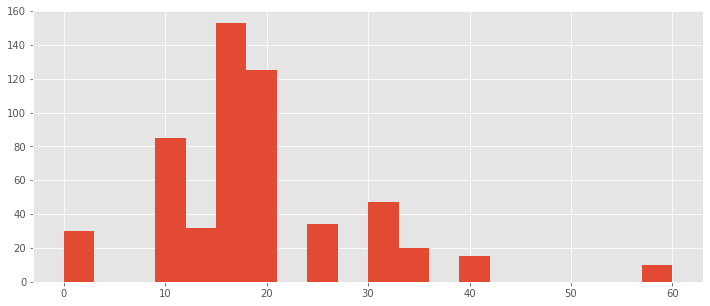

In [527]:
df.drop_duplicates(subset=['iid']).pf_o_att.hist(bins=20)

In [529]:
df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
             axis=1)

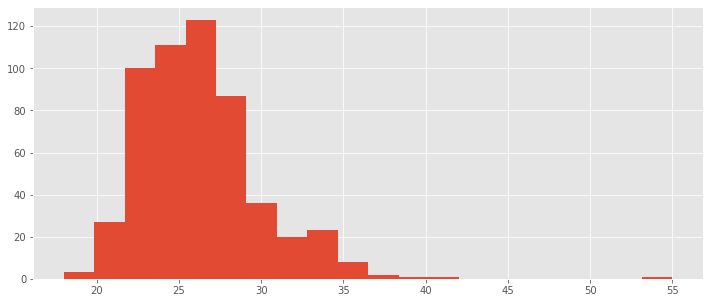

In [530]:
df.drop_duplicates(subset=['iid']).age.hist(bins=20)

In [532]:
df = df.dropna(subset=['age'])

In [535]:
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)

In [536]:
df = df.drop(['field'], axis=1)

In [539]:
df = df.drop(['undergra'], axis=1)

In [541]:
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)

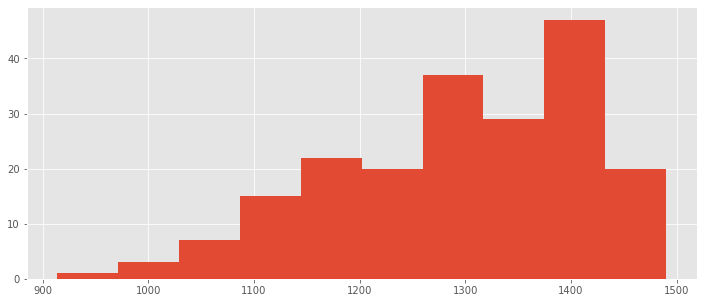

In [544]:
df.drop_duplicates('iid').mn_sat.hist()

In [546]:
# Что будем делать?
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].fillna(0)

In [549]:
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)

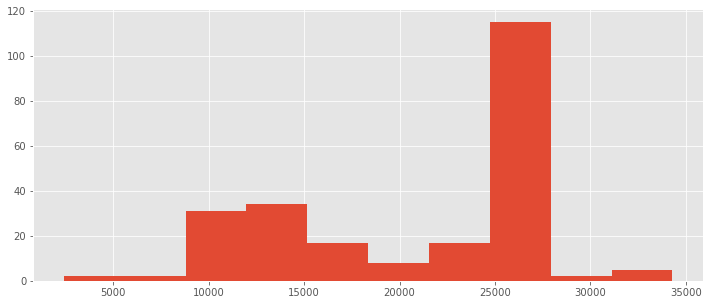

In [550]:
df.drop_duplicates('iid').tuition.hist()

In [552]:
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].fillna(0) 

In [556]:
df = df.dropna(subset=['imprelig', 'imprace'])

In [557]:
df = df.drop(['from', 'zipcode'], axis=1)

In [558]:
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)

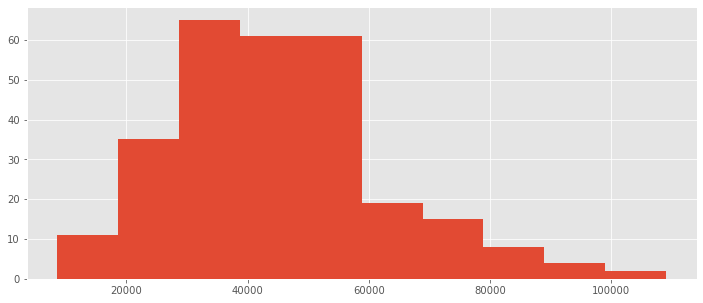

In [559]:
df.drop_duplicates('iid').loc[:, 'income'].hist()

In [561]:
#df = df.drop(['income'], axis=1)
df.loc[:, 'income'] = df.loc[:, 'income'].fillna(-999)

In [563]:
df = df.dropna(subset=['date'])

In [566]:
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)

In [567]:
df = df.drop(['career'], axis=1)

In [569]:
df.loc[:, ['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga']
      ].isnull().sum()

sports      0
tvsports    0
exercise    0
dining      0
museums     0
art         0
hiking      0
gaming      0
clubbing    0
reading     0
tv          0
theater     0
movies      0
concerts    0
music       0
shopping    0
yoga        0
dtype: int64

In [570]:
df = df.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)

In [573]:
df = df.drop(['expnum'], axis=1)

In [575]:
for col in list(df.iloc[:,-10:].columns):
    df[col] = df[col].fillna(df[col].max() + 1)

### Attr1

In [576]:
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

In [577]:
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]

In [578]:
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

In [579]:
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 99)

In [580]:
temp.loc[idx, ]

,iid,wave,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,totalsum
918,67,3,20.0,15.0,20.0,20.0,5.0,10.0,90.0
1530,105,4,30.0,15.0,20.0,20.0,0.0,5.0,90.0
7221,489,19,20.0,10.0,20.0,20.0,20.0,0.0,90.0
7586,517,21,15.0,20.0,20.0,20.0,5.0,10.0,90.0
7784,526,21,10.0,10.0,30.0,20.0,10.0,15.0,95.0


In [581]:
idx = ((temp.wave >= 6) & (temp.wave <= 9))

In [582]:
temp.loc[idx, ]

,iid,wave,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,totalsum
1846,132,6,16.67,16.67,16.67,16.67,16.67,16.67,100.02
1851,133,6,12.77,19.15,17.02,17.02,14.89,19.15,100.00
1856,134,6,6.67,20.00,20.00,17.78,20.00,15.56,100.01
1861,135,6,18.18,22.73,18.18,13.64,13.64,13.64,100.01
1871,137,6,17.39,17.39,15.22,17.39,13.04,19.57,100.00
...,...,...,...,...,...,...,...,...,...
3308,229,9,21.43,16.67,21.43,16.67,11.90,11.90,100.00
3328,230,9,23.81,23.81,23.81,23.81,2.38,2.38,100.00
3348,231,9,18.60,20.93,23.26,23.26,2.33,11.63,100.01
3368,232,9,17.78,17.78,17.78,17.78,13.33,15.56,100.01


Ну понятно, надо чутка подредактировать исходные признаки и в бой

In [583]:
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)

In [584]:
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

In [585]:
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']]

,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1
0,15.0,20.0,20.0,15.0,15.0,15.0
1,15.0,20.0,20.0,15.0,15.0,15.0
2,15.0,20.0,20.0,15.0,15.0,15.0
3,15.0,20.0,20.0,15.0,15.0,15.0
4,15.0,20.0,20.0,15.0,15.0,15.0
...,...,...,...,...,...,...
8373,70.0,0.0,15.0,15.0,0.0,0.0
8374,70.0,0.0,15.0,15.0,0.0,0.0
8375,70.0,0.0,15.0,15.0,0.0,0.0
8376,70.0,0.0,15.0,15.0,0.0,0.0


Проведите аналогичную работу для признаков `attr2`

### Attr2

In [586]:
feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']

In [587]:
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]

In [588]:
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

In [589]:
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 90) & (temp.totalsum != 0)

In [590]:
temp.loc[idx, ]

,iid,wave,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,totalsum
4816,320,12,20.0,10.0,10.0,10.0,20.0,10.0,80.0


In [591]:
idx = ((temp.wave >= 6) & (temp.wave <= 9))

In [592]:
temp.loc[idx, ]

,iid,wave,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,totalsum
1846,132,6,22.73,15.91,13.64,15.91,13.64,18.18,100.01
1851,133,6,24.32,16.22,13.51,16.22,10.81,18.92,100.00
1856,134,6,20.51,15.38,12.82,20.51,12.82,17.95,99.99
1861,135,6,18.75,16.67,14.58,18.75,18.75,12.50,100.00
1871,137,6,14.89,17.02,17.02,17.02,14.89,19.15,99.99
...,...,...,...,...,...,...,...,...,...
3308,229,9,15.22,19.57,15.22,17.39,21.74,10.87,100.01
3328,230,9,16.67,16.67,16.67,16.67,16.67,16.67,100.02
3348,231,9,18.18,11.36,15.91,18.18,20.45,15.91,99.99
3368,232,9,19.15,17.02,17.02,17.02,14.89,14.89,99.99


In [593]:
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)

In [594]:
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

In [595]:
df = df.drop(['temp_totalsum'], axis=1)

Признаки `attr4` и `attr5` пока выбросим

In [596]:
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)

Теперь создалим таблицу с мужчинами, таблицу с женщинами с сджоиним их

In [597]:
df = df.drop(['wave'], axis=1)

In [598]:
df

,iid,gender,pid,match,int_corr,samerace,age,field_cd,mn_sat,tuition,...,dec,attr,sinc,intel,fun,amb,shar,like,prob,met
0,1,0,11.0,0,0.14,0,21.0,1.0,0.0,0.0,...,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0
1,1,0,12.0,0,0.54,0,21.0,1.0,0.0,0.0,...,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0
2,1,0,13.0,1,0.16,1,21.0,1.0,0.0,0.0,...,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,11.0,1.0
3,1,0,14.0,1,0.61,0,21.0,1.0,0.0,0.0,...,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0,2.0
4,1,0,15.0,1,0.21,0,21.0,1.0,0.0,0.0,...,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,1,526.0,0,0.64,0,25.0,18.0,0.0,0.0,...,0,3.0,5.0,5.0,5.0,11.0,11.0,2.0,5.0,0.0
8374,552,1,527.0,0,0.71,0,25.0,18.0,0.0,0.0,...,0,4.0,6.0,8.0,4.0,4.0,11.0,4.0,4.0,0.0
8375,552,1,528.0,0,-0.46,0,25.0,18.0,0.0,0.0,...,0,4.0,7.0,8.0,8.0,8.0,11.0,6.0,5.0,0.0
8376,552,1,529.0,0,0.62,0,25.0,18.0,0.0,0.0,...,0,4.0,6.0,5.0,4.0,11.0,5.0,5.0,5.0,0.0


In [599]:
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()

df_female.columns = df_female.columns + '_f'

In [600]:
df_male

,iid,pid,match,int_corr,samerace,age,field_cd,mn_sat,tuition,race,...,dec,attr,sinc,intel,fun,amb,shar,like,prob,met
100,11,1.0,0,0.14,0,27.0,8.0,0.0,0.0,2.0,...,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0
101,11,2.0,0,0.29,1,27.0,8.0,0.0,0.0,2.0,...,0,8.0,7.0,6.0,9.0,7.0,4.0,7.0,2.0,2.0
102,11,3.0,0,-0.24,1,27.0,8.0,0.0,0.0,2.0,...,0,7.0,8.0,6.0,5.0,8.0,4.0,5.0,2.0,1.0
103,11,4.0,0,-0.18,1,27.0,8.0,0.0,0.0,2.0,...,0,6.0,7.0,8.0,7.0,7.0,5.0,6.0,3.0,2.0
104,11,5.0,0,-0.43,1,27.0,8.0,0.0,0.0,2.0,...,0,6.0,8.0,8.0,8.0,7.0,6.0,6.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,526.0,0,0.64,0,25.0,18.0,0.0,0.0,2.0,...,0,3.0,5.0,5.0,5.0,11.0,11.0,2.0,5.0,0.0
8374,552,527.0,0,0.71,0,25.0,18.0,0.0,0.0,2.0,...,0,4.0,6.0,8.0,4.0,4.0,11.0,4.0,4.0,0.0
8375,552,528.0,0,-0.46,0,25.0,18.0,0.0,0.0,2.0,...,0,4.0,7.0,8.0,8.0,8.0,11.0,6.0,5.0,0.0
8376,552,529.0,0,0.62,0,25.0,18.0,0.0,0.0,2.0,...,0,4.0,6.0,5.0,4.0,11.0,5.0,5.0,5.0,0.0


In [601]:
df_female

,iid_f,pid_f,age_f,field_cd_f,mn_sat_f,tuition_f,race_f,imprace_f,imprelig_f,income_f,...,dec_f,attr_f,sinc_f,intel_f,fun_f,amb_f,shar_f,like_f,prob_f,met_f
0,1,11.0,21.0,1.0,0.0,0.0,4.0,2.0,4.0,69487.0,...,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0
10,2,11.0,24.0,1.0,0.0,0.0,2.0,2.0,5.0,65929.0,...,0,5.0,7.0,8.0,4.0,6.0,3.0,6.0,4.0,2.0
20,3,11.0,25.0,2.0,0.0,0.0,2.0,8.0,4.0,-999.0,...,0,7.0,9.0,10.0,7.0,8.0,9.0,8.0,7.0,1.0
30,4,11.0,23.0,1.0,0.0,0.0,2.0,1.0,1.0,37754.0,...,0,4.0,10.0,8.0,5.0,8.0,7.0,6.0,7.0,2.0
40,5,11.0,21.0,1.0,0.0,0.0,2.0,8.0,1.0,86340.0,...,0,5.0,8.0,8.0,2.0,2.0,2.0,7.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7762,525,531.0,24.0,15.0,1360.0,26062.0,2.0,2.0,8.0,36510.0,...,0,6.0,9.0,9.0,5.0,8.0,7.0,5.0,6.0,0.0
7784,526,531.0,26.0,11.0,1188.0,11311.0,3.0,5.0,2.0,-999.0,...,1,4.0,3.0,9.0,4.0,9.0,5.0,9.0,1.0,0.0
7806,527,531.0,24.0,11.0,1290.0,15309.0,6.0,5.0,5.0,32386.0,...,0,4.0,8.0,9.0,3.0,8.0,2.0,4.0,3.0,0.0
7850,529,531.0,22.0,5.0,1430.0,26908.0,4.0,4.0,1.0,-999.0,...,1,4.0,6.0,5.0,5.0,6.0,5.0,6.0,7.0,0.0


In [602]:
data = df_male.merge(df_female, how = 'inner', left_on = 'pid', right_on = 'iid_f')

In [603]:
data = data.drop(['iid', 'pid', 'iid_f', 'pid_f'], axis = 1)

In [604]:
y = data.match

In [605]:
y

0       0
1       0
2       1
3       1
4       1
       ..
3994    0
3995    0
3996    0
3997    0
3998    0
Name: match, Length: 3999, dtype: int64

In [606]:
data = data.drop(['match'], axis = 1) #уберем таргет

In [607]:
y.mean()

0.16354088522130533

In [608]:
data

,int_corr,samerace,age,field_cd,mn_sat,tuition,race,imprace,imprelig,income,...,dec_f,attr_f,sinc_f,intel_f,fun_f,amb_f,shar_f,like_f,prob_f,met_f
0,0.14,0,27.0,8.0,0.0,0.0,2.0,7.0,3.0,-999.0,...,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0
1,0.54,0,22.0,1.0,0.0,0.0,2.0,1.0,1.0,29237.0,...,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0
2,0.16,1,22.0,1.0,0.0,0.0,4.0,3.0,5.0,-999.0,...,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0
3,0.61,0,23.0,1.0,0.0,0.0,2.0,1.0,1.0,56580.0,...,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0
4,0.21,0,24.0,1.0,0.0,0.0,3.0,3.0,1.0,36782.0,...,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994,0.23,0,30.0,8.0,0.0,0.0,2.0,8.0,8.0,-999.0,...,1,6.0,7.0,8.0,7.0,7.0,5.0,6.0,6.0,0.0
3995,0.29,0,28.0,8.0,0.0,0.0,2.0,2.0,3.0,-999.0,...,1,6.0,7.0,8.0,7.0,7.0,5.0,6.0,6.0,0.0
3996,-0.20,0,30.0,8.0,0.0,0.0,2.0,5.0,6.0,-999.0,...,1,6.0,7.0,8.0,7.0,7.0,5.0,6.0,6.0,0.0
3997,-0.32,0,27.0,8.0,1400.0,26019.0,1.0,2.0,1.0,55138.0,...,1,6.0,7.0,8.0,7.0,7.0,5.0,6.0,6.0,0.0


Сделаем еще некоторые признаки, которые будут показывать похожесть людей

In [609]:
data['age_diff'] = data['age'] - data['age_f'] #разница в возрасте
data['income_diff'] = data['income'] - data['income_f'] #разница в доходе
data['race_diff'] = data['race'] - data['race_f'] # и т.д
data['date_diff'] = data['date'] - data['date_f']
data['go_out_diff'] = data['go_out'] - data['go_out_f']
data['exphappy_diff'] = data['exphappy'] - data['exphappy_f']
data['tuition_diff'] = data['tuition'] - data['tuition_f']
data['mn_sat_diff'] = data['mn_sat'] - data['mn_sat_f']
data['imprace_diff'] = data['imprace'] - data['imprace_f']
data['imprelig_diff'] = data['imprelig'] - data['imprelig_f']

In [610]:
feat = ['dec', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob', 'met']
for f in feat[1:]:
    data[f + '_diff'] = data[f] - data[f + '_f']

In [611]:
data['like_min'] = data[['like','like_f']].min(axis=1)

In [612]:
feat = ['attr', 'sinc', 'intel', 'fun', 'amb']
for i in range(1,4):
    for f in feat:
        data[f + str(i) + '_1_diff'] = data[f + str(i) + '_1'] - data[f + str(i) + '_1_f']

In [613]:
for i in range(1,3):
    f = 'shar'
    data[f + str(i) + '_1_diff'] = data[f + str(i) + '_1'] - data[f + str(i) + '_1_f'] 

In [614]:
data['goal_pair'] = data['goal'] == data['goal_f'] #одинаковые цели
data['field_pair'] = data['field_cd'] == data['field_cd_f']#одинаковая область деятельности
data['career_pair'] = data['career_c'] == data['career_c_f']# и т.д
data['race_pair'] = data['race'] == data['race_f']

In [615]:
data = data.drop(['dec', 'dec_f'], axis = 1)

In [616]:
data

,int_corr,samerace,age,field_cd,mn_sat,tuition,race,imprace,imprelig,income,...,sinc3_1_diff,intel3_1_diff,fun3_1_diff,amb3_1_diff,shar1_1_diff,shar2_1_diff,goal_pair,field_pair,career_pair,race_pair
0,0.14,0,27.0,8.0,0.0,0.0,2.0,7.0,3.0,-999.0,...,1.0,0.0,-1.0,-2.0,-10.0,0.0,False,False,False,False
1,0.54,0,22.0,1.0,0.0,0.0,2.0,1.0,1.0,29237.0,...,1.0,2.0,1.0,2.0,-15.0,-5.0,False,True,False,False
2,0.16,1,22.0,1.0,0.0,0.0,4.0,3.0,5.0,-999.0,...,-1.0,0.0,0.0,-4.0,-3.0,9.0,True,True,False,True
3,0.61,0,23.0,1.0,0.0,0.0,2.0,1.0,1.0,56580.0,...,1.0,1.0,1.0,2.0,-10.0,15.0,True,True,False,False
4,0.21,0,24.0,1.0,0.0,0.0,3.0,3.0,1.0,36782.0,...,-1.0,1.0,-1.0,2.0,5.0,5.0,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994,0.23,0,30.0,8.0,0.0,0.0,2.0,8.0,8.0,-999.0,...,1.0,1.0,1.0,3.0,-10.0,0.0,False,False,False,False
3995,0.29,0,28.0,8.0,0.0,0.0,2.0,2.0,3.0,-999.0,...,1.0,0.0,-1.0,2.0,-10.0,-10.0,False,False,False,False
3996,-0.20,0,30.0,8.0,0.0,0.0,2.0,5.0,6.0,-999.0,...,-2.0,-2.0,-2.0,0.0,-26.0,-16.0,True,False,False,False
3997,-0.32,0,27.0,8.0,1400.0,26019.0,1.0,2.0,1.0,55138.0,...,-1.0,-1.0,-6.0,-2.0,-30.0,-20.0,False,False,False,False


In [617]:
for col in data.columns:
    if data[col].dtype =='float':
        data[col] = data[col].round(4) 

### Обучение

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [401]:
params = {'criterion' : ['gini', 'error', 'entropy'],
          'max_depth' : [5, 10, 15, 20],
          'min_samples_split': [2, 5, 10]}

In [402]:
kf = StratifiedKFold(n_splits=5, shuffle = True)

In [403]:
grid_search = GridSearchCV(MyDecisionTreeClassifier(), param_grid = params, cv = 5,
                           scoring = 'roc_auc', n_jobs=-1, verbose=True)

In [404]:
grid_search.fit(data, np.array(y))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  5.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=MyDecisionTreeClassifier(criterion='gini', max_depth=5,
                                                min_samples_split=2),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'error', 'entropy'],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=True)

In [405]:
grid_search.best_score_, grid_search.best_params_

(0.6997941643472743,
 {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10})

Лучший критерий - Джини, лучшее качество - 0.699

## Графики

In [385]:
X = np.array(data)
y = np.array(y)

In [386]:
train_ind, test_ind = next(kf.split(data, y))

In [387]:
train_ind.shape, test_ind.shape

((3199,), (800,))

In [388]:
import tqdm

In [389]:
train_score = []
test_score = []

In [390]:
for depth in tqdm.tqdm(np.concatenate((np.arange(1, 10), np.arange(10, 36, 4)))):
    d_tree = MyDecisionTreeClassifier(criterion = 'gini', min_samples_split = 2, max_depth = depth)
    d_tree.fit(X[train_ind], y[train_ind])
    train_score.append(roc_auc_score(y[train_ind], d_tree.predict_proba(X[train_ind])[:,1]))
    test_score.append(roc_auc_score(y[test_ind], d_tree.predict_proba(X[test_ind])[:,1]))

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:06<00:00,  4.15s/it]


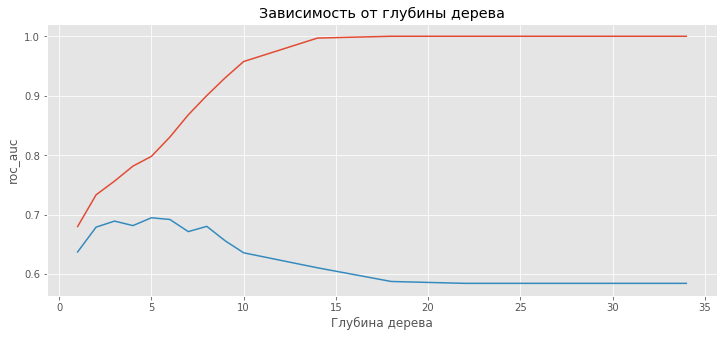

In [391]:
plt.plot(np.concatenate((np.arange(1, 10), np.arange(10, 36, 4))), train_score, label = 'train_score')
plt.plot(np.concatenate((np.arange(1, 10), np.arange(10, 36, 4))), test_score, label = 'test_score')
plt.xlabel('Глубина дерева')
plt.ylabel('roc_auc')
plt.title('Зависимость от глубины дерева')
plt.show()

С увеличением глубины дерева, скор на тестовой выборке становится 1, а скор на тестовой выборке начинает падать из-за переобучения.

In [398]:
train_score = []
test_score = []

In [399]:
for samples in tqdm.tqdm(np.arange(1, 10)):
    d_tree = MyDecisionTreeClassifier(criterion = 'gini', min_samples_split = samples, max_depth = 10)
    d_tree.fit(X[train_ind], y[train_ind])
    train_score.append(roc_auc_score(y[train_ind], d_tree.predict_proba(X[train_ind])[:,1]))
    test_score.append(roc_auc_score(y[test_ind], d_tree.predict_proba(X[test_ind])[:,1]))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:34<00:00,  3.88s/it]


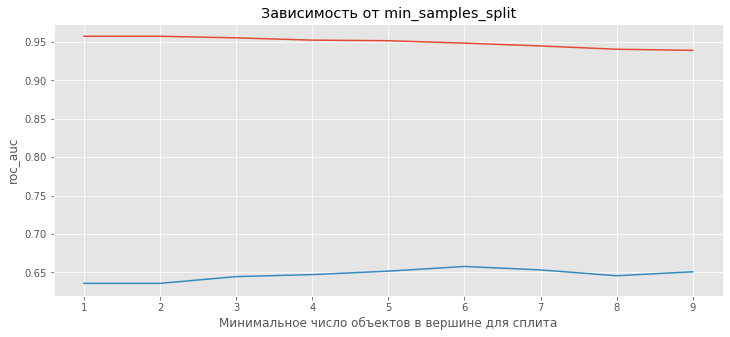

In [400]:
plt.plot(np.arange(1, 10), train_score, label = 'train_score')
plt.plot(np.arange(1, 10), test_score, label = 'test_score')
plt.xlabel('Минимальное число объектов в вершине для сплита')
plt.ylabel('roc_auc')
plt.title('Зависимость от min_samples_split')
plt.show()

С увеличением min_samples_split качество на тренировочной выборке начинает падать, т.к в литьях теперь больше 1 элемента, и алгоритм теряет уверенность в своем решении (если в листьях объекты разных классов)

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [468]:
d_tree = MyDecisionTreeClassifier(criterion = 'gini', min_samples_split = 10, max_depth = 5)
d_tree.fit(X[train_ind], y[train_ind])

Топ 10 признаков

In [469]:
data.columns[np.argsort(d_tree.get_feature_importance())[::-1]][:10]

Index(['intel1_1_f', 'prob_f', 'fun', 'age_f', 'shar1_1_f', 'fun3_1',
       'shar2_1_diff', 'attr_f', 'intel_diff', 'like'],
      dtype='object')

<BarContainer object of 121 artists>

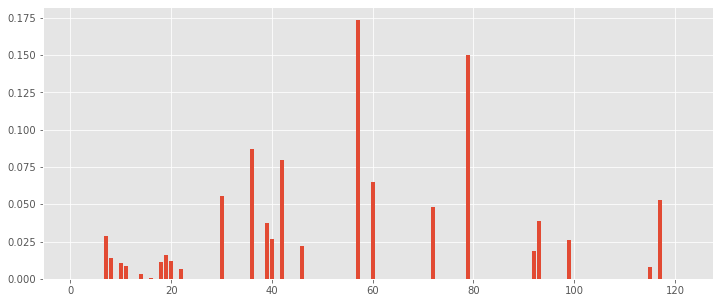

In [470]:
plt.bar(np.arange(1, data.shape[1] + 1), d_tree.get_feature_importance())

Среди которых есть довольно логичные, такие как: 

    -уровень привлекательности партнера
    -оценка веселости партнера
    -похожесть уровня интелегентности
    -похожесть разделяемых интересов
    и т.д

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

